## Data Exploration

##### Goals:
- To see the nature of the datasets i.e. their columns, null values, number of records, etc.
- To see overall statistics — no. of tv shows, no. of movies, types of movie categories, etc.

#### Importing Libraries


In [113]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

#### Loading CSV files into SQLite Database

In [114]:
# Loading as pandas tables first
netflix = pd.read_csv("data/netflix_titles.csv")
imdb_mov = pd.read_csv("data/IMDb movies.csv")
imdb_rat = pd.read_csv("data/IMDb ratings.csv")

# loading the pandas tables into netflix_imdb database as three separate tables
conn = sqlite3.connect('netflix_imdb.db')
cursor = conn.cursor()
netflix.to_sql("netflix", conn, if_exists="replace", index=False)
imdb_mov.to_sql("imdb_m", conn, if_exists="replace", index=False)
imdb_rat.to_sql("imdb_r", conn, if_exists="replace", index=False)

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_28454/3551321202.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_mov = pd.read_csv("data/IMDb movies.csv")


85855

#### Previewing data
Notes:
- Some records have director = None

In [115]:
print('='*60)
print('NETFLIX DATA PREVIEW')
print('='*60)
cursor.execute("SELECT * FROM netflix LIMIT 5;") # SQL query to preview
pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description]).head()

NETFLIX DATA PREVIEW


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",None,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,None,None,None,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [116]:
print('='*60)
print('IMDB MOVIES DATA PREVIEW')
print('='*60)
cursor.execute("SELECT * FROM imdb_m LIMIT 5;") # SQL query to preview
pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description]).head()

IMDB MOVIES DATA PREVIEW


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,None,None,None,None,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,None,None,None,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",None,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,None,None,None,None,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,None,None,None,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,None,None,None,None,31.0,14.0


In [117]:
print('='*60)
print('IMDB RATINGS DATA PREVIEW')
print('='*60)
cursor.execute("SELECT * FROM imdb_r LIMIT 5;") # SQL query to preview
pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description]).head()

IMDB RATINGS DATA PREVIEW


,imdb_title_id,weighted_average_vote,total_votes,mean_vote,median_vote,votes_10,votes_9,votes_8,votes_7,votes_6,...,females_30age_avg_vote,females_30age_votes,females_45age_avg_vote,females_45age_votes,top1000_voters_rating,top1000_voters_votes,us_voters_rating,us_voters_votes,non_us_voters_rating,non_us_voters_votes
0,tt0000009,5.9,154,5.9,6.0,12,4,10,43,28,...,5.7,13.0,4.5,4.0,5.7,34.0,6.4,51.0,6.0,70.0
1,tt0000574,6.1,589,6.3,6.0,57,18,58,137,139,...,6.2,23.0,6.6,14.0,6.4,66.0,6.0,96.0,6.2,331.0
2,tt0001892,5.8,188,6.0,6.0,6,6,17,44,52,...,5.8,4.0,6.8,7.0,5.4,32.0,6.2,31.0,5.9,123.0
3,tt0002101,5.2,446,5.3,5.0,15,8,16,62,98,...,5.5,14.0,6.1,21.0,4.9,57.0,5.5,207.0,4.7,105.0
4,tt0002130,7.0,2237,6.9,7.0,210,225,436,641,344,...,7.3,82.0,7.4,77.0,6.9,139.0,7.0,488.0,7.0,1166.0


#### Column Exploration:

Comments:
- There are two title columns in IMDb movies table which have to be reconciled to connect with        netflix table
- The imdb_title_id will be used to connect the imdb movies and imdb ratings table
- Countries, cast, and listed_in columns in netflix table has multiple countries separated by commas.

In [118]:
print('='*60)
print("NETFLIX DATASET COLUMNS AND TYPES")
print("(column_index, name, data type, not null, default value, is primary key)")
print('='*60)
cursor.execute("PRAGMA table_info(netflix);")
for col in cursor.fetchall():
    print(col)

print('='*60)
print("IMDB MOVIES DATASET COLUMNS AND TYPES")
print("(column_index, name, data type, not null, default value, is primary key)")
print('='*60)
cursor.execute("PRAGMA table_info(imdb_m);")
for col in cursor.fetchall():
    print(col)

print('='*60)
print("IMDB RATINGS DATASET COLUMNS AND TYPES")
print("(column_index, name, data type, not null, default value, is primary key)")
print('='*60)
cursor.execute("PRAGMA table_info(imdb_r);")
for col in cursor.fetchall():
    print(col)

NETFLIX DATASET COLUMNS AND TYPES
(column_index, name, data type, not null, default value, is primary key)
(0, 'show_id', 'TEXT', 0, None, 0)
(1, 'type', 'TEXT', 0, None, 0)
(2, 'title', 'TEXT', 0, None, 0)
(3, 'director', 'TEXT', 0, None, 0)
(4, 'cast', 'TEXT', 0, None, 0)
(5, 'country', 'TEXT', 0, None, 0)
(6, 'date_added', 'TEXT', 0, None, 0)
(7, 'release_year', 'INTEGER', 0, None, 0)
(8, 'rating', 'TEXT', 0, None, 0)
(9, 'duration', 'TEXT', 0, None, 0)
(10, 'listed_in', 'TEXT', 0, None, 0)
(11, 'description', 'TEXT', 0, None, 0)
IMDB MOVIES DATASET COLUMNS AND TYPES
(column_index, name, data type, not null, default value, is primary key)
(0, 'imdb_title_id', 'TEXT', 0, None, 0)
(1, 'title', 'TEXT', 0, None, 0)
(2, 'original_title', 'TEXT', 0, None, 0)
(3, 'year', 'TEXT', 0, None, 0)
(4, 'date_published', 'TEXT', 0, None, 0)
(5, 'genre', 'TEXT', 0, None, 0)
(6, 'duration', 'INTEGER', 0, None, 0)
(7, 'country', 'TEXT', 0, None, 0)
(8, 'language', 'TEXT', 0, None, 0)
(9, 'director', '

##### Found: In imdb movies dataset, title not equal to original title when title is translated in English

In [119]:
# Since there are two title columns in imdb movies table (imdb_m), let's check discrepencies:
cursor.execute("SELECT title, original_title FROM imdb_m where title is not original_title") # SQL query

# converted to a dataframe for better formatting
pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description]).head()

,title,original_title
0,Il calvario di una madre,Ingeborg Holm
1,Amore di madre,"Home, Sweet Home"
2,Lo studente di Praga,Der Student von Prag
3,La madonnina del porto,Tess of the Storm Country
4,Nascita di una nazione,The Birth of a Nation


##### Found: Some netflix and imdb titles are repeated with different imdb_ratings

Example: title = Paranoid

In the IMDb dataset specifically, there's nuance:
- Many films have the same titles, but are created by different direcors.
- Some have same titles and same directors, but they are released in different years, possibly remakes.
- Even then, there are some which are released in the same year, but their durations and languages are different.

So in this way, **all entries in IMDb dataset are unique**

In [120]:
# Joining the two datasets on title alone (note: not good as titles are repeated,
#                                           need to find addtional join parameters)
cursor.execute("""
               SELECT
                    n.title  AS netflix_title,
                    i.title AS imdb_title,
                    i.avg_vote AS imdb_rating
                FROM netflix n
                JOIN imdb_m i
                ON n.title = i.title;
                """) # SQL JOIN query to see IMDb ratings of movies and tvshows on netflix.

# # investigating the matter
cursor.execute("""
               SELECT title, year, director, duration,language
                FROM imdb_m
                WHERE (title, director, year) IN (
                    SELECT title, director, year
                    FROM imdb_m
                    GROUP BY title, director, year
                    HAVING COUNT(*) > 1
                )
                ORDER BY title;
                """)
pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])

,title,year,director,duration,language
0,Anno Domini 681,1981,Ludmil Staikov,323,Bulgarian
1,Anno Domini 681,1981,Ludmil Staikov,95,"English, Bulgarian"
2,Don Chisciotte,1933,Georg Wilhelm Pabst,73,English
3,Don Chisciotte,1933,Georg Wilhelm Pabst,73,French
4,I violenti di Rio Bravo,1965,Robert Siodmak,102,German
5,I violenti di Rio Bravo,1965,Robert Siodmak,101,German
6,Shadow of Chinatown,1936,Robert F. Hill,281,English
7,Shadow of Chinatown,1936,Robert F. Hill,71,English
8,The Lost Jungle,1934,"David Howard, Armand Schaefer",243,English
9,The Lost Jungle,1934,"David Howard, Armand Schaefer",68,English


#### Category statistics:

- There are only 8,807 netflix titles but 86,855 titles registered in IMDb datasets

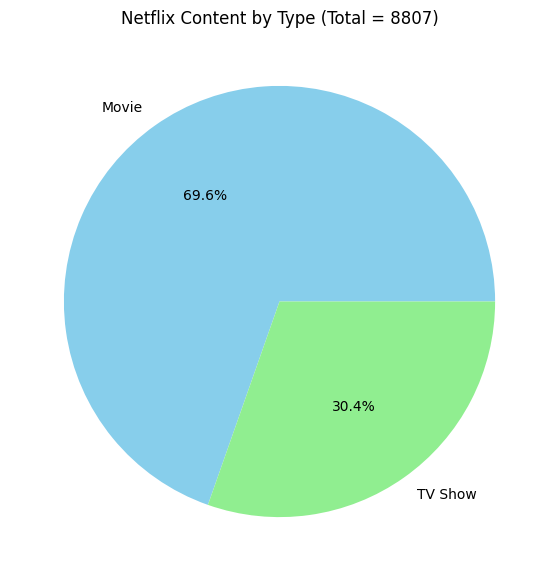

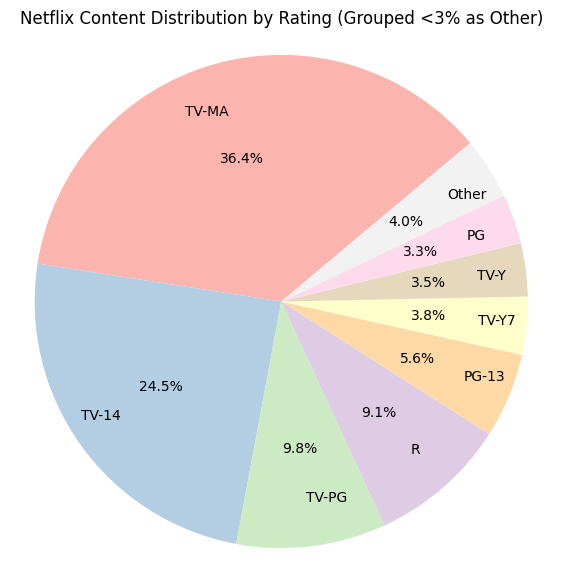

In [121]:
cursor.execute("SELECT COUNT(*) FROM netflix;") # Querying total listing counts
total_listings = cursor.fetchall()[0][0]

############# Content Type Pie Chart VISUALIZATION #############
cursor.execute("SELECT type, COUNT(*) as count FROM netflix GROUP BY type") # Querying movie counts
df = pd.DataFrame(cursor.fetchall(), columns=[desc[0] for desc in cursor.description])
df.set_index('type').plot.pie(y='count', autopct='%1.1f%%', figsize=(7,7), legend=False, colors=['skyblue','lightgreen'])
plt.ylabel('')
plt.title(f"Netflix Content by Type (Total = {total_listings})")
plt.show()
#########################################


############# Age Ratings Pie Chart VISUALIZATION #############
df = pd.read_sql_query("SELECT rating FROM netflix where rating IS NOT NULL", conn)
rating_counts = df['rating'].value_counts()

# Compute percentage of each rating
total = rating_counts.sum()
rating_pct = rating_counts / total

# Group ratings with <3% into 'Other'
rating_counts_grouped = rating_counts.copy()
rating_counts_grouped[rating_pct < 0.03] = 0
other_sum = rating_counts[rating_pct < 0.03].sum()

# Drop zero rows and add 'Other'
rating_counts_grouped = rating_counts_grouped[rating_counts_grouped > 0]
rating_counts_grouped['Other'] = other_sum

plt.figure(figsize=(7,7))
plt.pie(
    rating_counts_grouped,
    labels=rating_counts_grouped.index,
    autopct='%1.1f%%',
    startangle=40,
    colors=plt.cm.Pastel1.colors,
    labeldistance=0.8
)
plt.title("Netflix Content Distribution by Rating (Grouped <3% as Other)")
plt.axis('equal')  # keeps pie circular
plt.show()
#########################################
#################################################################

print("="*60)
cursor.execute("SELECT COUNT(*) FROM imdb_m;") # SQL SELECT query
total_imdb_listings = cursor.fetchall()[0][0]



#### Release Year Histograms for IMDb listings

Seeing how many movies released per year and the average IMDb rating across time

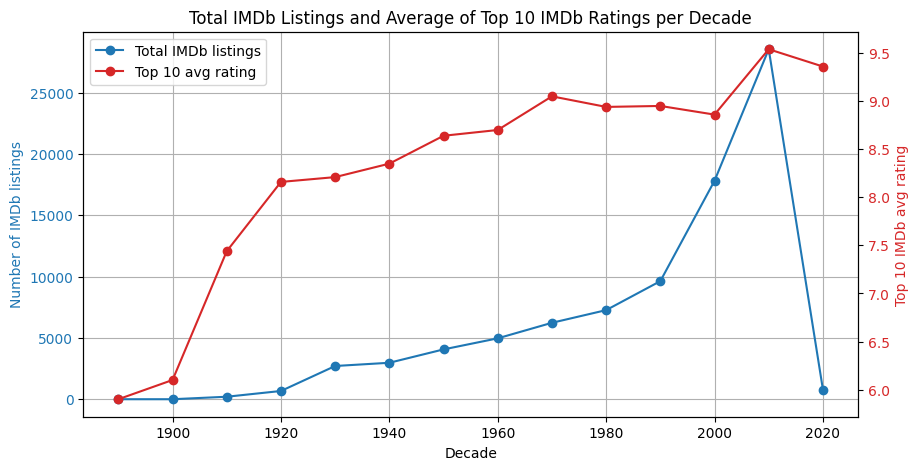

============================== Comments ==============================

      - The total number of IMDb listings have increased over the decades as more movies have been made.
      - The drop in 2020 is because the dataset ends at 2020 and the datapoint was supposed to aggregate
      movie counts from 2020-2025
      - Plotting the average of top 10 IMDb ratings per decade points that the roughly the quality of movies is increasing.
      


In [122]:
query = """
SELECT
    (CAST(year AS INTEGER) / 10) * 10 AS decade,
    COUNT(*) AS count
FROM imdb_m
WHERE CAST(year AS INTEGER) > 0
GROUP BY decade
ORDER BY decade ASC;
"""

df = pd.read_sql(query, conn) # total counts df

query = """
    WITH ranked AS (
        SELECT
            *,
            ((CAST(year AS INTEGER) / 10) * 10) AS decade,
            ROW_NUMBER() OVER (
                PARTITION BY ((CAST(year AS INTEGER) / 10) * 10)
                ORDER BY avg_vote DESC
            ) AS rn
        FROM imdb_m
        WHERE CAST(year AS INTEGER) > 0 AND avg_vote IS NOT NULL
        )
    SELECT
        decade,
        COUNT(*) AS count,
        AVG(avg_vote) AS top10_avg_vote
    FROM ranked
    WHERE rn <= 10  -- only top 10 per decade
    GROUP BY decade
    ORDER BY decade ASC;
"""
df_top_10_avg_ratings = pd.read_sql(query, conn)

# Plot
df_plot = df.merge(df_top_10_avg_ratings[['decade', 'top10_avg_vote']], on='decade', how='left')

fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis: total count
ax1.plot(df_plot['decade'], df_plot['count'], color='tab:blue', marker='o', label='Total IMDb listings')
ax1.set_xlabel("Decade")
ax1.set_ylabel("Number of IMDb listings", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Right y-axis: top 10 average rating
ax2 = ax1.twinx()
ax2.plot(df_plot['decade'], df_plot['top10_avg_vote'], color='tab:red', marker='o', label='Top 10 avg rating')
ax2.set_ylabel("Top 10 IMDb avg rating", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optional: combined legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Title and grid
plt.title("Total IMDb Listings and Average of Top 10 IMDb Ratings per Decade")
ax1.grid(True)
plt.show()
print("="*30,"Comments","="*30)
print("""
      - The total number of IMDb listings have increased over the decades as more movies have been made.
      - The drop in 2020 is because the dataset ends at 2020 and the datapoint was supposed to aggregate
      movie counts from 2020-2025
      - Plotting the average of top 10 IMDb ratings per decade points that the roughly the quality of movies is increasing.
      """)

#### Countries Statistics

==================== TOP 10 COUNTRIES WHERE NETFLIX LISTINGS ARE AVAILABLE OR MADE ====================


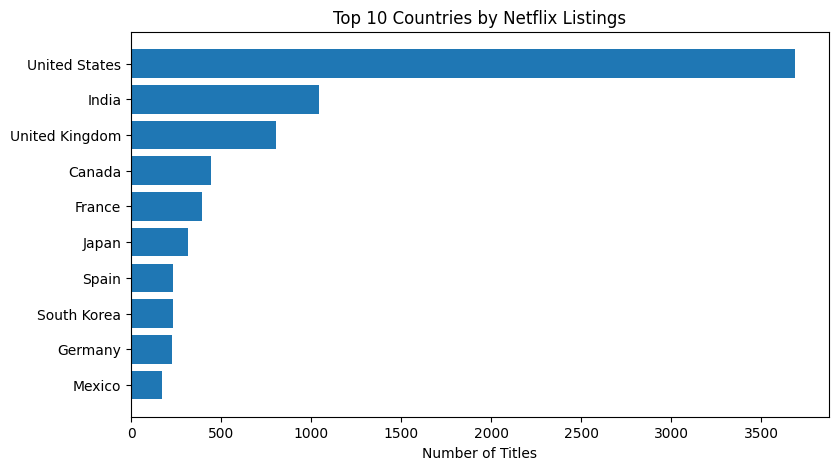

In [123]:
print("="*20, "TOP 10 COUNTRIES WHERE NETFLIX LISTINGS ARE AVAILABLE OR MADE","="*20)


query = """
        SELECT country, COUNT(*) AS count  FROM netflix
        WHERE country IS NOT NULL
        GROUP BY country
        ORDER BY count DESC
"""
df = pd.read_sql_query(query, conn) # some records in df have mulltiple countries in the country column

# So we have to get all rows and then write custom logic to get the counts in python and then sort.
cursor.execute("""
                SELECT country
                FROM netflix
                WHERE country IS NOT NULL
                """)

from collections import Counter
country_counter = Counter() # a good built in functionality for countign using a dictionary: default value = 0.

for (countries,) in cursor: # countries = 'Argentina, France' for example.
    for country in countries.split(','): # country = 'Argentina' and then country = ' France'
        country_counter[country.strip()] += 1

country_df = (
    pd.DataFrame(country_counter.items(), columns=['country', 'count'])
      .sort_values(by='count', ascending=False)
      .head(10)
)

################### VISUALIZATION ##############
plt.figure(figsize=(9,5))
plt.barh(country_df['country'], country_df['count'])
plt.xlabel("Number of Titles")
plt.title("Top 10 Countries by Netflix Listings")
plt.gca().invert_yaxis()  # largest at top
plt.show()
#################################################

#### NETFLIX Director Statistics

==================== TOP 10 DIRECTORS OF NETFLIX LISTINGS ====================


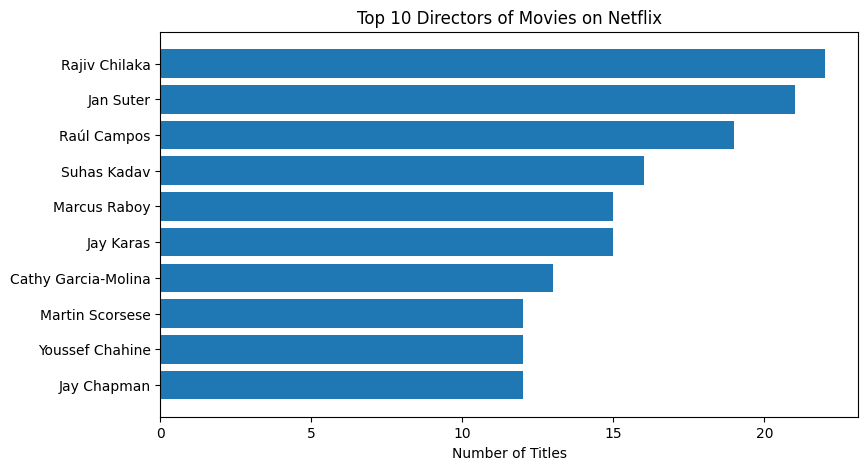

In [124]:
print("="*20, "TOP 10 DIRECTORS OF NETFLIX LISTINGS","="*20)

# some records in df have mulltiple directors in the director column

# So we have to get all rows and then write custom logic to get the counts in python and then sort.
cursor.execute("""
                SELECT director
                FROM netflix
                WHERE director IS NOT NULL and type = 'Movie'
                """)

from collections import Counter
director_counter = Counter() # a good built in functionality for countign using a dictionary: default value = 0.

for (directors,) in cursor:
    for director in directors.split(','):
        director_counter[director.strip()] += 1

director_df_movies = (
    pd.DataFrame(director_counter.items(), columns=['director', 'count'])
      .sort_values(by='count', ascending=False)
      .head(10)
)

################### VISUALIZATION ##############
plt.figure(figsize=(9,5))
plt.barh(director_df_movies['director'], director_df_movies['count'])
plt.xlabel("Number of Titles")
plt.title("Top 10 Directors of Movies on Netflix")
plt.gca().invert_yaxis()  # largest at top
plt.show()
#################################################

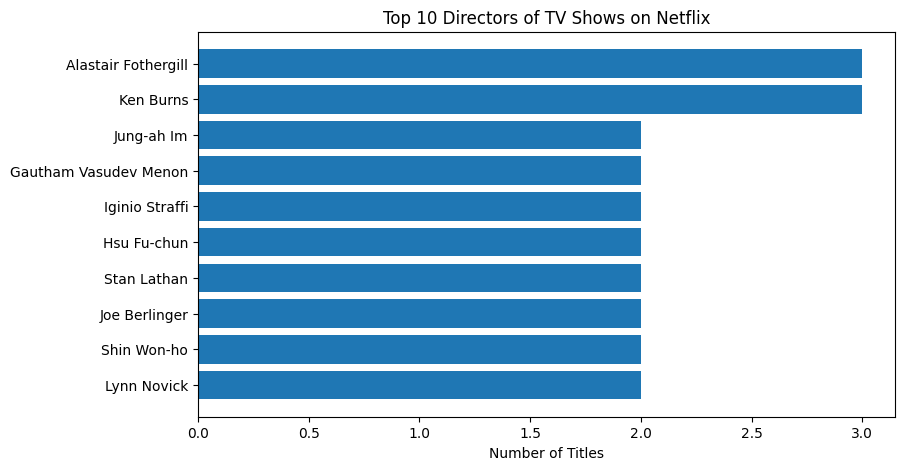

In [125]:
cursor.execute("""
                SELECT director
                FROM netflix
                WHERE director IS NOT NULL and type = 'TV Show'
                """) # getting TV show directors

from collections import Counter
director_counter = Counter() # a good built in functionality for countign using a dictionary: default value = 0.

for (directors,) in cursor:
    for director in directors.split(','):
        director_counter[director.strip()] += 1

director_df_shows = (
    pd.DataFrame(director_counter.items(), columns=['director', 'count'])
      .sort_values(by='count', ascending=False)
      .head(10)
)
################### VISUALIZATION ##############
plt.figure(figsize=(9,5))
plt.barh(director_df_shows['director'], director_df_shows['count'])
plt.xlabel("Number of Titles")
plt.title("Top 10 Directors of TV Shows on Netflix")
plt.gca().invert_yaxis()  # largest at top
plt.show()
#################################################

#### IMDb director statistics

==================== TOP 10 DIRECTORS OF IMDb LISTINGS ====================


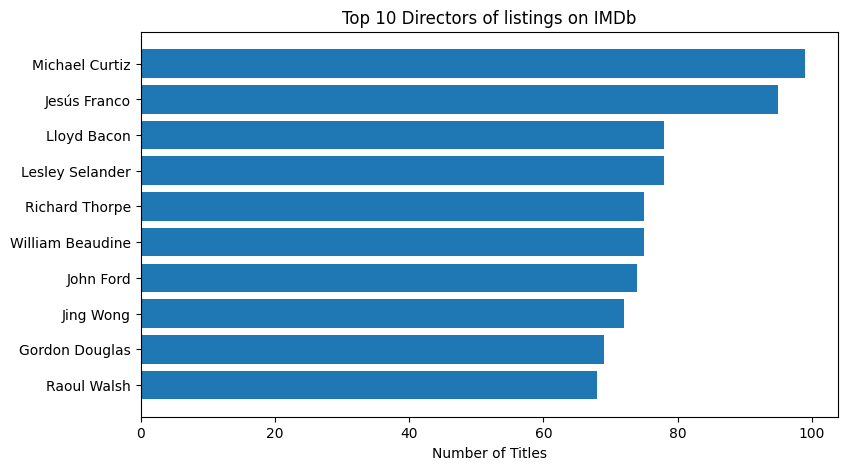

,director,count
42,Michael Curtiz,99
1821,Jesús Franco,95
309,Lloyd Bacon,78
682,Lesley Selander,78
462,Richard Thorpe,75
212,William Beaudine,75
72,John Ford,74
5541,Jing Wong,72
638,Gordon Douglas,69
54,Raoul Walsh,68


In [126]:
print("="*20, "TOP 10 DIRECTORS OF IMDb LISTINGS","="*20)

# some records in df have mulltiple directors in the director column

# So we have to get all rows and then write custom logic to get the counts in python and then sort.
cursor.execute("""
                SELECT director
                FROM imdb_m
                WHERE director IS NOT NULL
                """)

from collections import Counter
director_counter = Counter() # a good built in functionality for countign using a dictionary: default value = 0.

for (directors,) in cursor:
    for director in directors.split(','):
        director_counter[director.strip()] += 1

director_df_imdb = (
    pd.DataFrame(director_counter.items(), columns=['director', 'count'])
      .sort_values(by='count', ascending=False)
      .head(10)
)

################### VISUALIZATION ##############
plt.figure(figsize=(9,5))
plt.barh(director_df_imdb['director'], director_df_imdb['count'])
plt.xlabel("Number of Titles")
plt.title("Top 10 Directors of listings on IMDb")
plt.gca().invert_yaxis()  # largest at top
plt.show()
#################################################
director_df_imdb

#### IMDb Top 10 Actors of all time

Comments:
- The analysis correctly suggests that Brahmanandam (Indian Comedy Drama Actor) has the most number of movies.
- In reality he has a Guiness World Record for over 1000 movies, but IMDb has only these many.

==================== TOP 10 ACTORS OF IMDb LISTINGS ====================


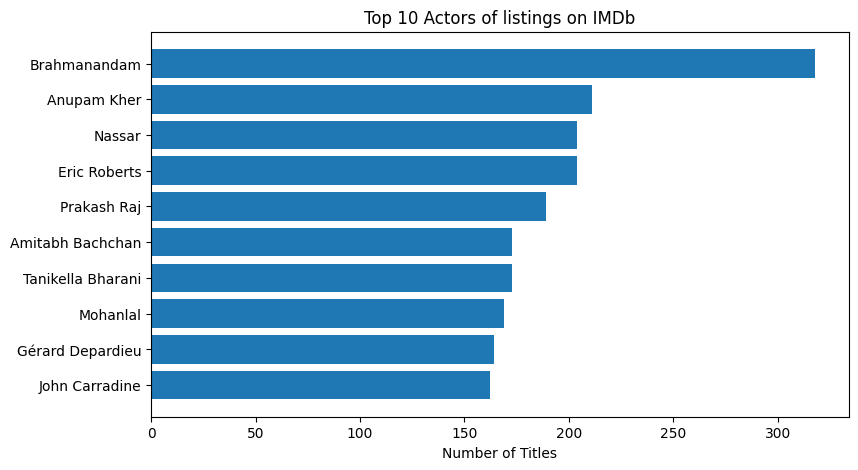

,actor,count
150619,Brahmanandam,318
85880,Anupam Kher,211
96620,Nassar,204
13121,Eric Roberts,204
113065,Prakash Raj,189
44979,Amitabh Bachchan,173
160284,Tanikella Bharani,173
93914,Mohanlal,169
47581,Gérard Depardieu,164
8226,John Carradine,162


In [127]:
print("="*20, "TOP 10 ACTORS OF IMDb LISTINGS","="*20)

# some records in df have mulltiple directors in the director column

# So we have to get all rows and then write custom logic to get the counts in python and then sort.
cursor.execute("""
                SELECT actors
                FROM imdb_m
                WHERE actors IS NOT NULL
                """)

from collections import Counter
actor_counter = Counter() # a good built in functionality for countign using a dictionary: default value = 0.

for (actors,) in cursor:
    for actor in actors.split(','):
        actor_counter[actor.strip()] += 1

actor_df = (
    pd.DataFrame(actor_counter.items(), columns=['actor', 'count'])
      .sort_values(by='count', ascending=False)
      .head(10)
)

################### VISUALIZATION ##############
plt.figure(figsize=(9,5))
plt.barh(actor_df['actor'], actor_df['count'])
plt.xlabel("Number of Titles")
plt.title("Top 10 Actors of listings on IMDb")
plt.gca().invert_yaxis()  # largest at top
plt.show()
#################################################
actor_df

#### IMDb Listing Genres

==================== TOP 10 Genres OF IMDb LISTINGS ====================


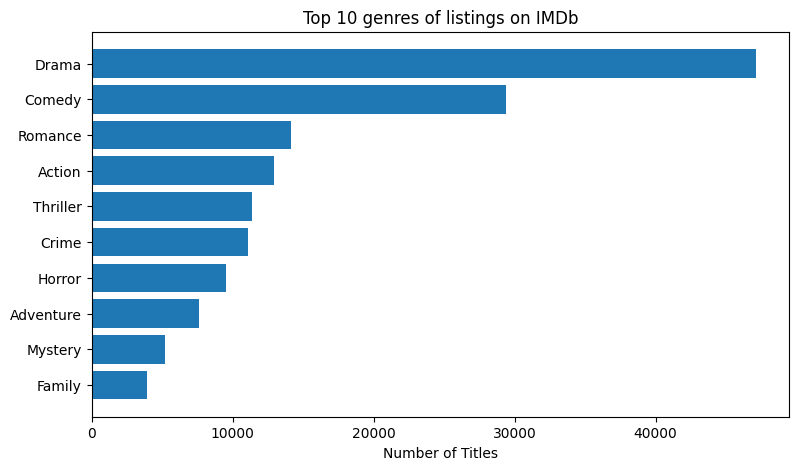


        COMMENTS:
        - These percentages are from the total movies in top 10 genres and not all.
        - Plus since a movie can have multiple genres, it simply shows a visual of dominating genres as they overlap.
      


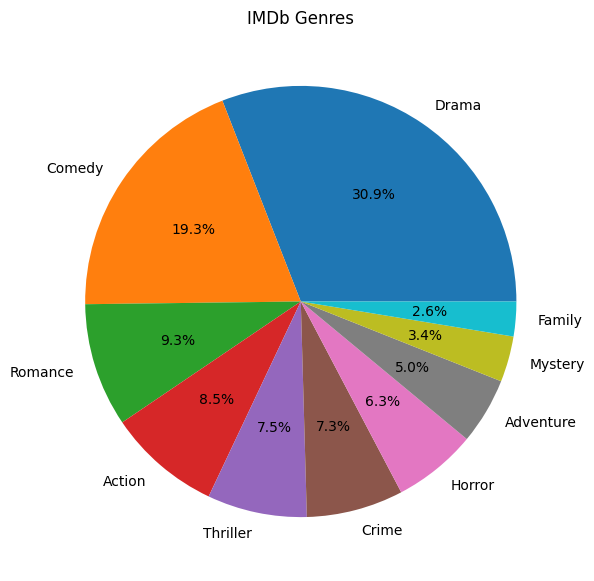

In [136]:
print("="*20, "TOP 10 Genres OF IMDb LISTINGS","="*20)

# some records in df have mulltiple directors in the director column

# So we have to get all rows and then write custom logic to get the counts in python and then sort.
cursor.execute("""
                SELECT genre
                FROM imdb_m
                WHERE genre IS NOT NULL
                """)

from collections import Counter
genre_counter = Counter() # a good built in functionality for countign using a dictionary: default value = 0.

for (genre,) in cursor:
    for genre in genre.split(','):
        genre_counter[genre.strip()] += 1

genre_df = (
    pd.DataFrame(genre_counter.items(), columns=['genre', 'count'])
      .sort_values(by='count', ascending=False)
      .head(10)
)

################### VISUALIZATION ##############
plt.figure(figsize=(9,5))
plt.barh(genre_df['genre'], genre_df['count'])
plt.xlabel("Number of Titles")
plt.title("Top 10 genres of listings on IMDb")
plt.gca().invert_yaxis()  # largest at top
plt.show()

print("""
        COMMENTS:
        - These percentages are from the total movies in top 10 genres and not all.
        - Plus since a movie can have multiple genres, it simply shows a visual of dominating genres as they overlap.
      """)
genre_df.set_index('genre').plot.pie(y='count', autopct='%1.1f%%', figsize=(7,7), legend=False)
plt.ylabel('')
plt.title(f"IMDb Genres")
plt.show()
#################################################